In [568]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon, powerlaw
from scipy.optimize import curve_fit
import os

In [570]:
# Load the height data
file_name = 'S4_10.50to18.54_scaled_heights.csv'  # Adjust the file name as needed
file_path = 'G:/Official_Vanda_Organizing/Spatial_Morphologic_Data/2_Data_Cleaning/3_Extracted_Maxima_and_Heights/Height_CSVs/' + file_name
data = pd.read_csv(file_path)

heights = data['Height'] 
#Heights = heights[heights > 0] #THIS NEEDS TO BE UNCOMMENTED FOR O SITES WHERE MANY HEIGHTS ARE TOO CLOSE TO 0 

# Sort the heights in descending order for exceedance probability calculation
heights_sorted = np.sort(heights)[::-1]
exceedance_prob = np.arange(1, len(heights_sorted) + 1) / len(heights_sorted)

In [572]:
# Define functions for power law, exponential, and truncated power law fits
def power_law(x, a, b):
    return a * x ** (-b)

def exponential(x, a, b):
    return a * np.exp(-b * x)

def truncated_power_law(x, a, b, c):
    return a * x ** (-b) * np.exp(-c * x)

# Fit the distributions to the data
params_powerlaw, _ = curve_fit(power_law, heights_sorted, exceedance_prob, maxfev=10000)
params_exponential, _ = curve_fit(exponential, heights_sorted, exceedance_prob, maxfev=10000)
params_truncated, _ = curve_fit(truncated_power_law, heights_sorted, exceedance_prob, maxfev=10000)

# Generate x values for plotting the fitted functions
x_vals = np.linspace(min(heights_sorted), max(heights_sorted), 1000)

# Calculate the fitted values
y_powerlaw = power_law(x_vals, *params_powerlaw)
y_exponential = exponential(x_vals, *params_exponential)
y_truncated = truncated_power_law(x_vals, *params_truncated)

# Calculate R-squared for each fit
def calculate_r2(y_obs, y_pred):
    ss_res = np.sum((y_obs - y_pred) ** 2)  # Sum of squared residuals
    ss_tot = np.sum((y_obs - np.mean(y_obs)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)

# R-squared for each model
r2_powerlaw = calculate_r2(exceedance_prob, power_law(heights_sorted, *params_powerlaw))
r2_exponential = calculate_r2(exceedance_prob, exponential(heights_sorted, *params_exponential))
r2_truncated = calculate_r2(exceedance_prob, truncated_power_law(heights_sorted, *params_truncated))

In [574]:
# Extract site and range information from the filename
base_name = os.path.splitext(file_name)[0]  # Remove the file extension
parts = base_name.split('_')  # Split based on underscores

# Assuming the filename has the structure "Site_Range_scaled_heights"
if len(parts) >= 2:
    site = parts[0]  # Site code, e.g., "C2"
    range_info = parts[1]  # Range, e.g., "8.14to9.05"
    # Format title using extracted information
    title = f"{site} ({range_info.replace('to', ' to ')}) Exceedance Probability with Best Fit Distributions"
else:
    raise ValueError("Filename format is incorrect. Expected format: Site_Range_scaled_heights.csv")

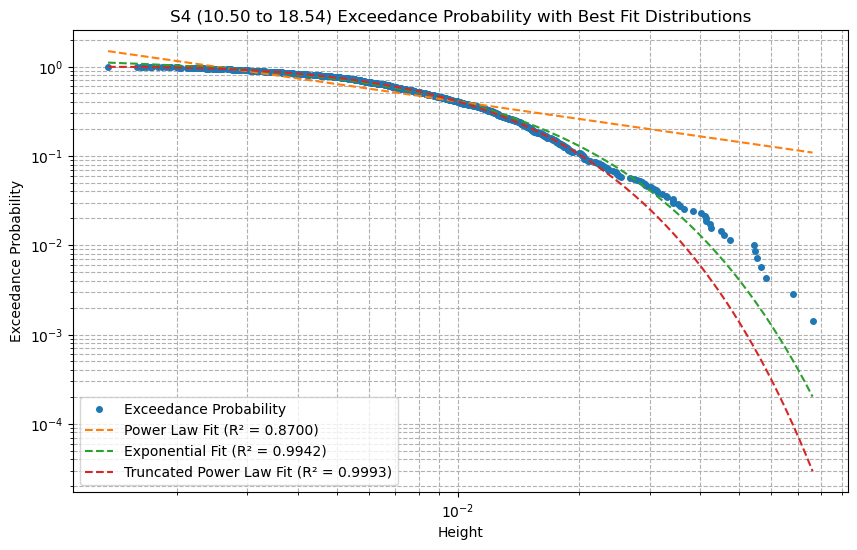

In [576]:
# Plot exceedance probability
plt.figure(figsize=(10, 6))
plt.plot(heights_sorted, exceedance_prob, 'o', label='Exceedance Probability', markersize=4)
plt.plot(x_vals, y_powerlaw, label=f'Power Law Fit (R² = {r2_powerlaw:.4f})', linestyle='--')
plt.plot(x_vals, y_exponential, label=f'Exponential Fit (R² = {r2_exponential:.4f})', linestyle='--')
plt.plot(x_vals, y_truncated, label=f'Truncated Power Law Fit (R² = {r2_truncated:.4f})', linestyle='--')

# Customize plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Height')
plt.ylabel('Exceedance Probability')
plt.title(title)
plt.legend()
plt.grid(True, which="both", ls="--")

# Save plot
save_path = os.path.splitext(file_path)[0] + '_bestfitdistribution.png'
#plt.savefig(save_path, format='png', dpi=300)

# Show the plot
plt.show()

In [578]:
# Print R-squared values
print(f"R² for Power Law Fit: {r2_powerlaw:.4f}")
print(f"R² for Exponential Fit: {r2_exponential:.4f}")
print(f"R² for Truncated Power Law Fit: {r2_truncated:.4f}")

R² for Power Law Fit: 0.8700
R² for Exponential Fit: 0.9942
R² for Truncated Power Law Fit: 0.9993


In [580]:
# Function to find transition point
def find_transition_point(b, c):
    # Solve for x where x^b = exp(c * x)
    # A numerical method, using curve fitting or solving directly for x
    # For simplicity, here we'll use an iterative approach
    
    # Define the difference between power law and exponential terms
    def difference(x):
        return (x ** b) - np.exp(c * x)
    
    # Use scipy.optimize to find the root of the difference function
    from scipy.optimize import fsolve
    transition_x = fsolve(difference, x0=1)  # Initial guess x0=1
    
    return transition_x[0]

# Extract parameters from the truncated power law fit
b_truncated, c_truncated = params_truncated[1], params_truncated[2]

# Find the transition point for the truncated power law fit
transition_point = find_transition_point(b_truncated, c_truncated)

# Print the transition point
print(f"The transition from power law to exponential occurs at approximately x = {transition_point:.5f}")


The transition from power law to exponential occurs at approximately x = 0.00678
